In [1]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools




## ex 1 - loading the dataset (it's only 1 column)

In [2]:
#ex 1 - loading the dataset (it's only 1 column)

df = pd.read_csv('bandwidth.csv')


#the bandwidth usage started on the 1st of january of 2019
# namdwidth is measured in Mbps (megabits per second) which equals 106 bps

start_date = '2019-1-1'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=len(df) - 1)
df['time'] = pd.date_range(start=start_date, end=end_date, freq='H')

df.set_index('time', inplace=True)
print(df)

                     hourly_bandwidth
time                                 
2019-01-01 00:00:00       1000.496714
2019-01-01 01:00:00       1000.969408
2019-01-01 02:00:00       1002.046019
2019-01-01 03:00:00       1004.702118
2019-01-01 04:00:00       1007.447816
...                               ...
2020-02-21 11:00:00        740.546059
2020-02-21 12:00:00        738.906228
2020-02-21 13:00:00        736.057995
2020-02-21 14:00:00        733.559640
2020-02-21 15:00:00        732.190049

[10000 rows x 1 columns]


## ex2 - Visualize the time series.

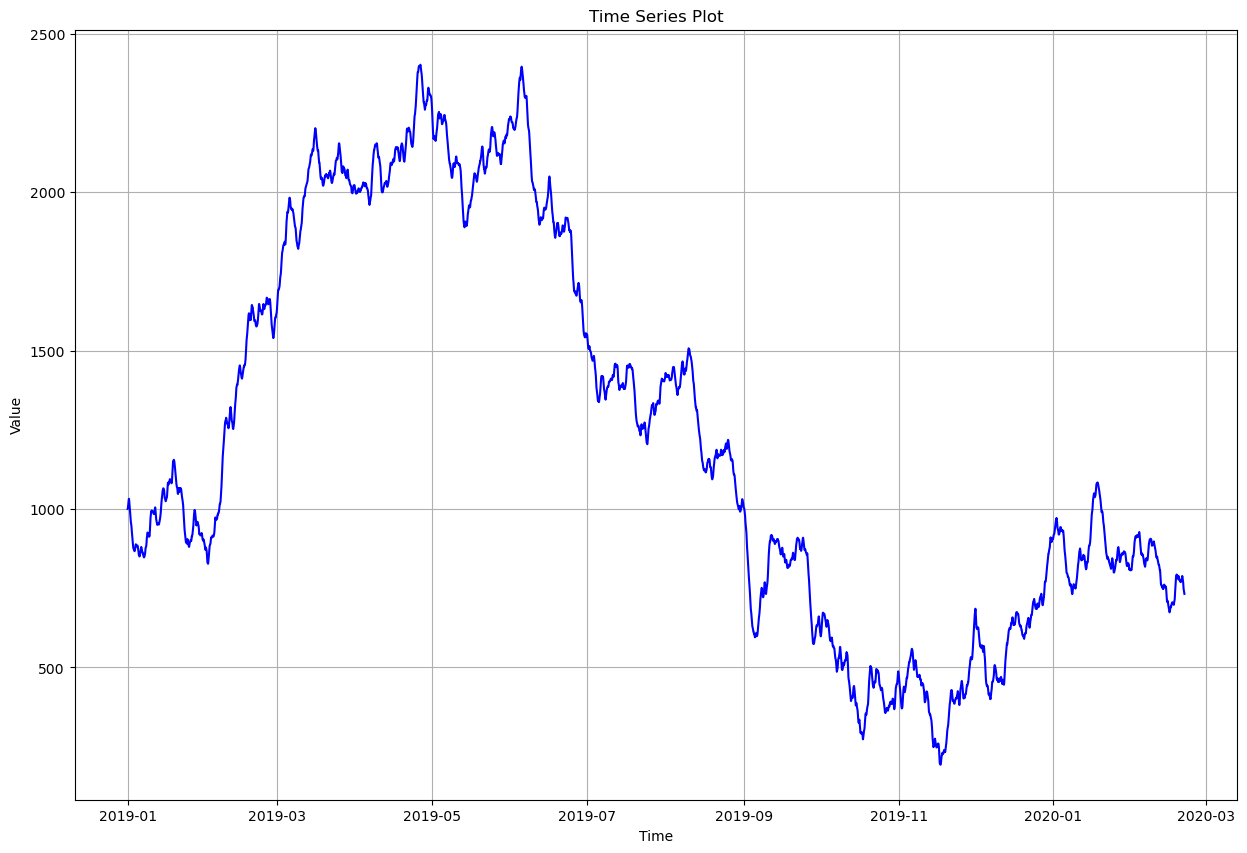

In [3]:
#ex2 - Visualize the time series.
#better to plot this time series

plt.figure(figsize=(15, 10))
plt.plot(df.index, df['hourly_bandwidth'], linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## ex 3 - Verify if the time series is stationary.

In [4]:
#ex3
# let's use the acrf to verify wether the time series is stationary

ADF_result = adfuller(df['hourly_bandwidth'])

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


KeyboardInterrupt: 

## ex4 - Based on your exploration, determine the most suitable model with the usual steps:

ADF Statistic: -20.695
p-value: 0.0
Time Series is Stationary!


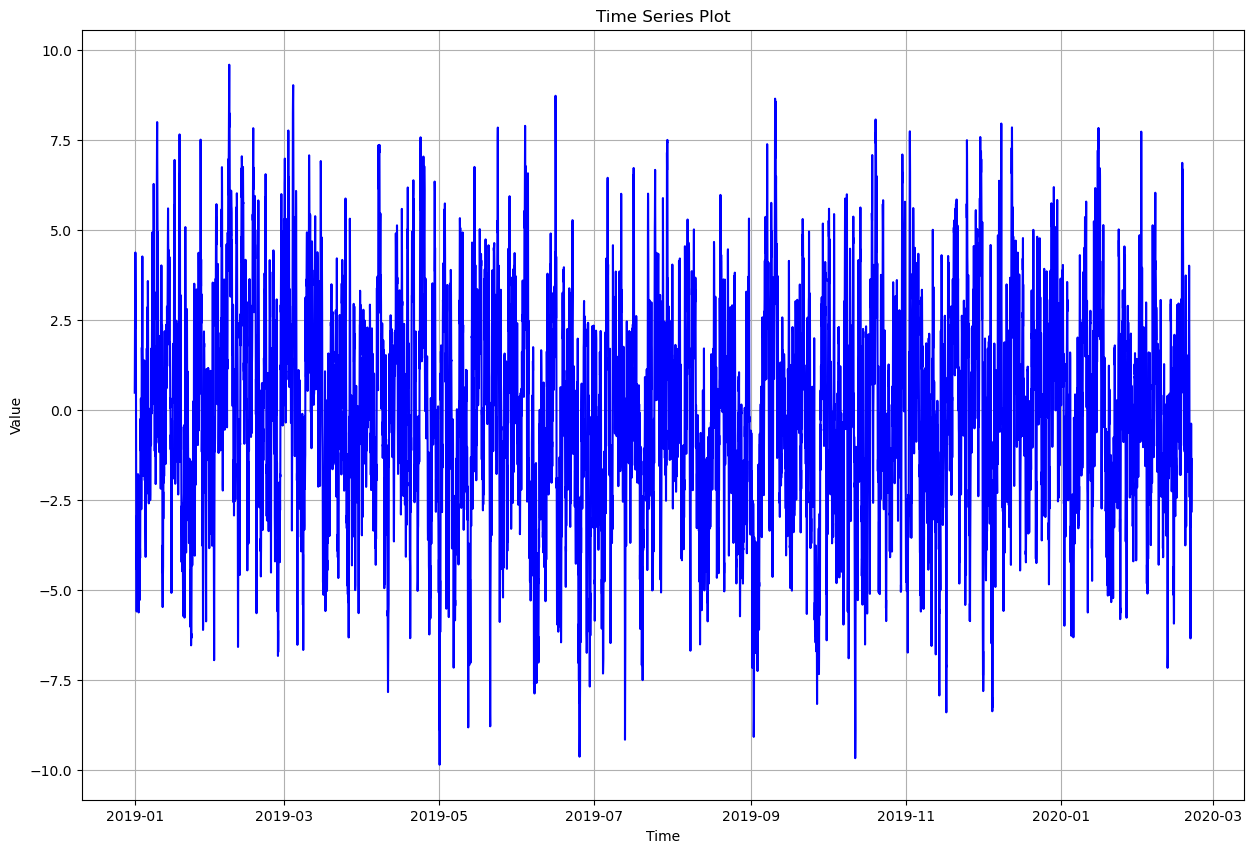

In [ ]:
# a. Apply the transformations to make the time series stationary

#let's apply differencing



df['hourly_bandwidth'] = df['hourly_bandwidth'].diff() # this will reduce the number of elements by 1
df.dropna(inplace=True)

ADF_result = adfuller(df['hourly_bandwidth'])

print(f"ADF Statistic: {round(ADF_result[0], 3)}")
print(f"p-value: {round(ADF_result[1], 3)}")

if round(ADF_result[1], 3) < 0.05:
    print('Time Series is Stationary!')
else:
    print('Time Series is not Stationary!')


plt.figure(figsize=(15, 10))
plt.plot(df.index, df['hourly_bandwidth'], linestyle='-', color='b')
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()




<Figure size 1200x400 with 0 Axes>

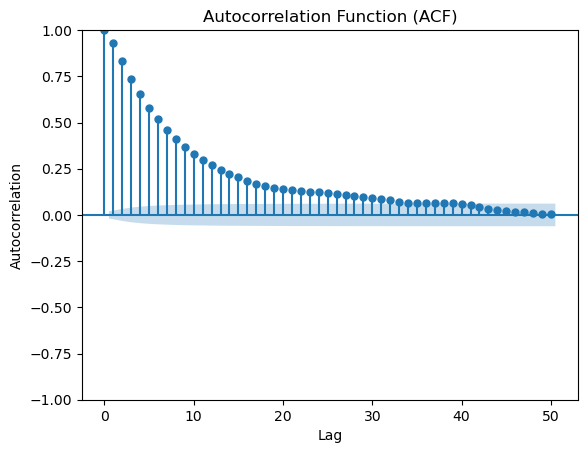

<Figure size 1200x400 with 0 Axes>

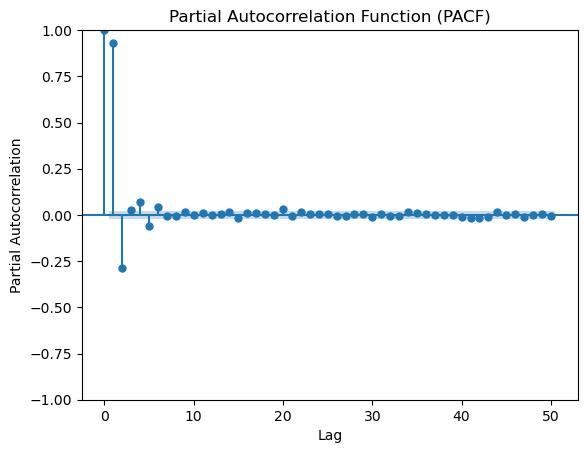

In [ ]:
# b. Determine the adequate model to predict the series by plotting the autocorrelation and partial


# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df['hourly_bandwidth'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


### Answer: the adequate model is ARMA(p, q)

In [ ]:
# autocorrelation functions
# c. Find the optimal (p , q) parameters.

def generate_order_list(x, y):
    # Generate all combinations of p and q within the specified range
    orders = list(itertools.product(range(x, y+1), repeat=2))

    # Filter out combinations where p and q are not distinct (optional)
    orders = [order for order in orders if order[0] != order[1]]

    return orders




def optimize_ARMA(data, order_list) -> pd.DataFrame:
    results = []
    for order in order_list:
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]), simple_differencing=False, freq=)
        except:
            continue

        aic = model.fit(disp=False).aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


print(optimize_ARMA(df['hourly_bandwidth'], generate_order_list(1, 5)))



best_aic = optimize_ARMA(df['hourly_bandwidth'], generate_order_list(1, 5))

/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/joao/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

     (p,q)           AIC
0   (3, 2)  28451.239020
1   (2, 3)  28451.415534
2   (1, 5)  28452.019940
3   (4, 2)  28452.797770
4   (2, 4)  28453.233812
5   (5, 2)  28453.287846
6   (4, 3)  28453.413771
7   (5, 3)  28454.072570
8   (1, 4)  28454.142962
9   (2, 5)  28454.279537
10  (4, 5)  28454.385342
11  (3, 4)  28455.374598
12  (3, 5)  28455.666369
13  (5, 4)  28456.621550
14  (5, 1)  28458.903053
15  (1, 3)  28462.681589
16  (4, 1)  28463.453262
17  (1, 2)  28511.683945
18  (3, 1)  28534.528098
19  (2, 1)  28559.689002


In [ ]:
# d. Fit the ARMA(p,q) model with the optimal parameters on the training set



In [ ]:
# e. Perform the residual analysis to validate if the model can be used to forecast.



In [ ]:
#ex5 - Predict a full week of the bandwidth usage using the last week of points as test set.

